# Evaluation and plotting for different experiments

- Write throughput (fio vs dd, isilon vs netapp)
- Containerized fio vs non-containerized fio

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as st

In [2]:
def load_data(filename, metric):
    data = load_file(filename)
    return extract_results(data, metric)

def load_file(filename):
    file = Path(filename)
    assert file.is_file()
    return json.loads(file.read_text())

def extract_results(data, metric, x_labels=None):
    x_labels = x_labels if x_labels else list(data["results"].keys())
    pd_data = []
    for label in x_labels:
        results = data["results"][label]
        values = [r[metric] for r in results]
        mean = np.mean(values)
        conf = confidence_interval(values)
        pd_data.append([mean, conf])


    df = pd.DataFrame(data=pd_data, index=x_labels, columns=["mean", "conf"])
    return df

def confidence_interval(values):
    confidence = 0.95
    dof = len(values)-1
    m = np.mean(values)
    sem = st.sem(values)
    interval = st.t.interval(alpha=confidence, df=dof, loc=m, scale=sem)
    if np.isnan(interval[0]) or np.isnan(interval[1]):
        return m * 10**-6
    return (interval[1]-interval[0])/2
    
def plot(filename, metric="write_bw_mean_in_mb"):
    data = load_file(filename)
    df = extract_results(data, metric=metric)
    print(df)
    ax = df["mean"].plot(kind='bar', rot=0, xlabel='Date', ylabel='Value', title='My Plot', figsize=(6, 4), yerr=df["conf"])
    plt.show()

## Experiment: Write throughput

- fio vs dd
- netapp vs isilon

<IPython.core.display.Javascript object>


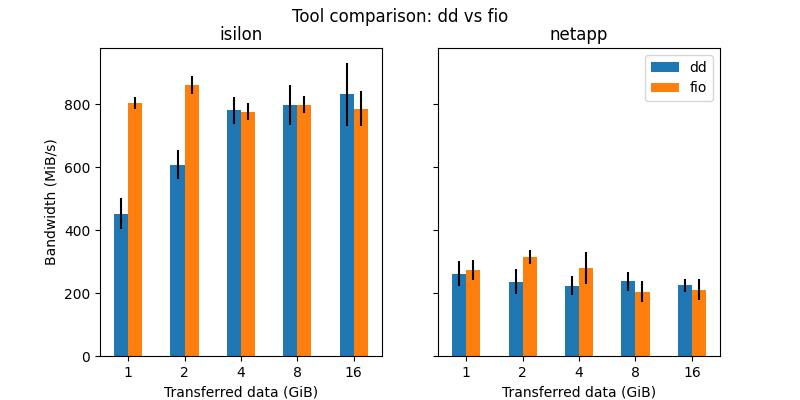

              mean        conf
fio 1   804.463162   20.510991
    2   862.671062   28.655294
    4   777.271908   26.003394
    8   799.276953   26.943301
    16  786.710232   54.611935
dd  1   452.800000   49.925084
    2   608.600000   46.305911
    4   781.000000   43.960868
    8   797.200000   63.248126
    16  832.200000  100.353801
              mean       conf
fio 1   273.829598  32.211917
    2   314.267345  23.098175
    4   278.713493  50.560371
    8   204.973719  34.125648
    16  211.207519  32.420014
dd  1   262.000000  38.751058
    2   235.600000  39.417699
    4   223.800000  29.414598
    8   237.400000  29.391003
    16  225.600000  20.732443


<IPython.core.display.Javascript object>


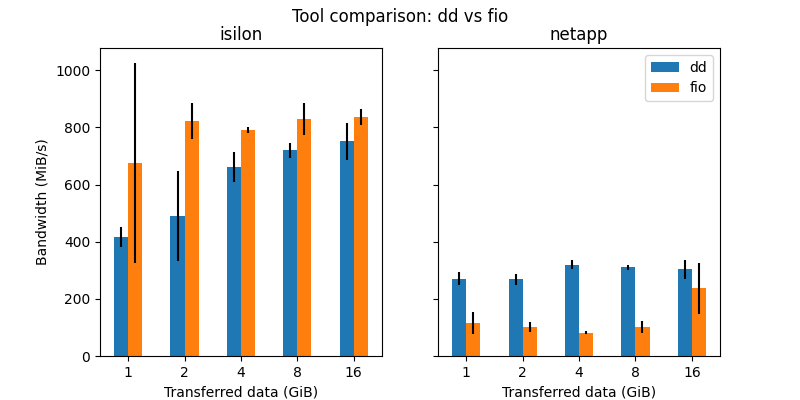

              mean        conf
fio 1   677.064727  349.829281
    2   823.692913   63.185023
    4   791.456177   10.664527
    8   829.964143   55.204397
    16  836.556407   28.673488
dd  1   416.364318   34.100336
    2   489.911156  157.438883
    4   662.452021   52.165977
    8   720.505083   26.415613
    16  751.710729   65.031849
              mean       conf
fio 1   116.572568  38.110153
    2   101.689755  17.240127
    4    82.211830   6.716786
    8   102.286360  20.145530
    16  237.296596  89.804013
dd  1   271.298812  21.156008
    2   268.189802  20.133059
    4   320.135242  17.039559
    8   311.201789   8.460057
    16  303.240804  33.937426


In [13]:
%matplotlib notebook
## Params
prefix_1 = "2022-05-28T18:08:38_throughput_write_"
prefix_2 = "2022-05-30T20:41:35_throughput_write_"

## Plot code
def do_plot(prefix, system, ax):
    df = pd.concat({
        f"fio": load_data(f"./results/{prefix}fio_{system}.json", "write_bw_mean_in_mb"),
        f"dd": load_data(f"./results/{prefix}dd_{system}.json", "bw_in_mb"),
    })
    df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16, "32G": 32}, inplace=True)
    df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16, "32768": 32}, inplace=True)
    #df.drop(32, axis=1, inplace=True)
    df.drop(index=[(f"fio", 32),(f"dd", 32)], inplace=True)
    print(df)

    df["mean"].unstack(level=0).plot(
        ax=ax,
        kind='bar', rot=0,
        xlabel='Transferred data (GiB)',
        ylabel='Bandwidth (MiB/s)',
        title=system,
        figsize=(8, 4),
        yerr=df["conf"].unstack(level=0)
    )
    
def do_plot_2(prefix, system, ax):
    df = pd.concat({
        f"fio": load_data(f"./results/{prefix}fio_{system}.json", "write_bw_mean_in_MiB"),
        f"dd": load_data(f"./results/{prefix}dd_{system}.json", "bw_in_MiB"),
    })
    df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16, "32G": 32}, inplace=True)
    df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16, "32768": 32}, inplace=True)
    #df.drop(32, axis=1, inplace=True)
    df.drop(index=[(f"fio", 32),(f"dd", 32)], inplace=True)
    print(df)

    df["mean"].unstack(level=0).plot(
        ax=ax,
        kind='bar', rot=0,
        xlabel='Transferred data (GiB)',
        ylabel='Bandwidth (MiB/s)',
        title=system,
        figsize=(8, 4),
        yerr=df["conf"].unstack(level=0)
    )

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Tool comparison: dd vs fio')
    
do_plot(prefix_1, "isilon", ax1)
do_plot(prefix_1, "netapp", ax2)
ax1.get_legend().remove()

plt.savefig("dd_vs_fio.png",bbox_inches='tight')
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Tool comparison: dd vs fio')
    
do_plot_2(prefix_2, "isilon", ax1)
do_plot_2(prefix_2, "netapp", ax2)
ax1.get_legend().remove()
plt.show()

## Experiment: Containerized vs non-containerized

                                        mean       conf
throughput_fio_containerized      860.579328  64.592593
throughput_fio_non_containerized  836.148429  43.159343


<IPython.core.display.Javascript object>


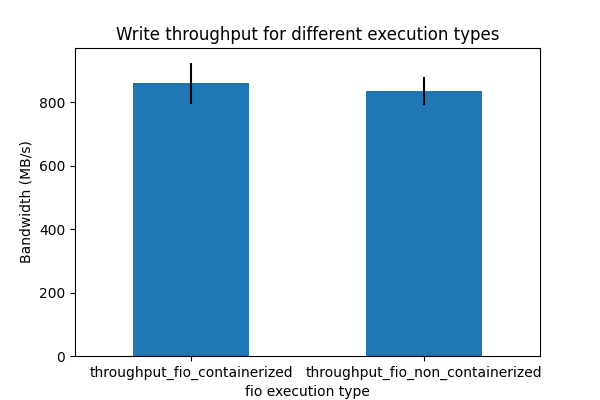

In [14]:
%matplotlib notebook
## Params
result_file_prefix = "2022-04-12T06:01:41_throughput_fio_"
result_file_prefix = "2022-05-24T02:25:53_throughput_fio_"

## Plot code
pre = result_file_prefix
df = pd.concat([
    load_data(f"../results/{pre}containerized.json", "write_bw_mean_in_mb").rename(index={"irods_server__mnt_isilon": "containerized"}),
    load_data(f"../results/{pre}non_containerized.json", "write_bw_mean_in_mb").rename(index={"irods_server__mnt_isilon": "non-containerized"}),
])
print(df)

ax = df["mean"].plot(
    kind='bar', rot=0,
    xlabel='fio execution type',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput for different execution types',
    figsize=(6, 4),
    yerr=df["conf"]
)
plt.show()

## Experiment: Compare isilon vs. netapp vs. fuse vs. davrods

In [6]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"
result_file_prefix = "2022-04-19T08:01:46_benchmark"
result_file_prefix = "2022-04-19T22:44:52_benchmark"
result_file_prefix1 = "2022-04-24T22:07:21_benchmark"
result_file_prefix2 = "2022-05-10T07:02:12_benchmark"

## Plot code
data_isilon1 = load_file(f"../results/{result_file_prefix1}_isilon.json")
data_isilon2 = load_file(f"../results/{result_file_prefix2}_isilon.json")
#data_netapp = load_file(f"../results/{result_file_prefix}_netapp.json")
#data_irods_fuse = load_file(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
#data_irods_davrods = load_file(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")
#data_irods_fuse_s3 = load_file(f"../results/{result_file_prefix}_irods_fuse_on_s3.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon1, metric, [label]),
        extract_results(data_isilon2, metric, [label]),
        #extract_results(data_netapp, metric, [label]),
        #extract_results(data_irods_fuse, metric, [label]),
        #extract_results(data_irods_davrods, metric, [label]),
        #extract_results(data_irods_fuse_s3, metric, [label]),
    ])
    print(df)




                        mean      conf
throughput_write   99.023088  0.619379
throughput_write  126.583062  3.420939
                       mean       conf
throughput_read  100.434809   9.754372
throughput_read  370.962375  27.413739
                   mean         conf
iops_write  3348.945972   406.854599
iops_write  4532.409169  1176.419927
                   mean        conf
iops_read  20517.825104  383.174700
iops_read  17253.772118  867.350218
                   mean      conf
latency_write  0.960222  0.023121
latency_write  1.890200  0.114710
                  mean      conf
latency_read  0.536071  0.012775
latency_read  0.708808  0.032046


In [7]:
## Params
result_file_prefix = "2022-04-18T15:21:17_benchmark"

## Plot code
data_isilon = load_file(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_file(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_file(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")

benchmarks = [
    ("throughput_write", "write_bw_mean_in_mb"),
    ("throughput_read", "read_bw_mean_in_mb"),
    ("iops_write", "write_iops_mean"),
    ("iops_read", "read_iops_mean"),
    ("latency_write", "write_lat_mean_in_ms"),
    ("latency_read", "read_lat_mean_in_ms"),
]

for label, metric in benchmarks:
    df = pd.concat([
        extract_results(data_isilon, metric, [label]),
        extract_results(data_netapp, metric, [label]),
        extract_results(data_irods_fuse, metric, [label]),
    ])
    print(df)



                        mean      conf
throughput_write   98.685998  0.068802
throughput_write   98.482835  0.161289
throughput_write  134.952795  1.269093
                      mean      conf
throughput_read  95.881488  3.320839
throughput_read  94.468629  0.365485
throughput_read  99.994432  0.126420
                    mean         conf
iops_write   3710.599657  1095.649276
iops_write  13774.541151  1368.937597
iops_write    794.592284     1.286878
                   mean         conf
iops_read  19207.208368   402.272921
iops_read  15687.604135  2593.205149
iops_read    800.625000     0.074255
                   mean      conf
latency_write  1.038045  0.042719
latency_write  3.042860  0.488825
latency_write  1.983074  0.226385
                  mean      conf
latency_read  0.534238  0.010611
latency_read  4.522136  0.547462
latency_read  2.701251  0.333236


In [15]:
## Params
result_file_prefix = "2022-04-25T15:47:32_mdtest"

## Plot code
data_isilon = load_file(f"../results/{result_file_prefix}_isilon.json")
data_netapp = load_file(f"../results/{result_file_prefix}_netapp.json")
data_irods_fuse = load_file(f"../results/{result_file_prefix}_irods_fuse_on_isilon.json")
data_irods_davrods = load_file(f"../results/{result_file_prefix}_irods_davrods_on_isilon.json")

metrics = [
    "dir_create",
    "dir_stat",
    "dir_rename",
    "dir_remove",
    "file_create",
    "file_stat",
    "file_read",
    "file_remove",
    "tree_create",
    "tree_remove",
]

for metric in metrics:
    print(metric)
    df = pd.concat([
        extract_results(data_isilon, metric),
        extract_results(data_netapp, metric),
        extract_results(data_irods_fuse, metric),
        extract_results(data_irods_davrods, metric),
    ])
    print(df)
    print()




dir_create
                                    mean        conf
mdtest_isilon                   195.0692  105.290020
mdtest_netapp                   137.5430   57.419667
mdtest_irods_fuse_on_isilon      44.7016    6.878651
mdtest_irods_davrods_on_isilon   56.1538    6.073183

dir_stat
                                       mean           conf
mdtest_isilon                   458066.2202  155468.307392
mdtest_netapp                   345333.3616  167402.243800
mdtest_irods_fuse_on_isilon     498550.5862   66372.716515
mdtest_irods_davrods_on_isilon   91911.9392   21695.084993

dir_rename
                                    mean        conf
mdtest_isilon                   421.5754  375.125824
mdtest_netapp                   136.0700   40.062452
mdtest_irods_fuse_on_isilon      42.1128    5.173145
mdtest_irods_davrods_on_isilon   36.1058    4.252653

dir_remove
                                    mean        conf
mdtest_isilon                   206.9110  206.691646
mdtest_netapp           

## Experiment: Compare isilon and netapp by daytime

In [19]:
# scp recycle_runner_dev:/srv/thesis_stefan/results/2022-05-09T1* .
from pathlib import Path
from datetime import datetime, timedelta
import json

folder = Path("/tmp/results")

res = {}

for file in folder.iterdir():
    date_str, _, _, _, system, num = file.stem.split("_")
    date = datetime.fromisoformat(date_str) + timedelta(hours=2)
    file_content = json.loads(file.read_text())
    
    run_res = file_content["results"][f"throughput_by_daytime_{system}_{num}"]
    if len(run_res) == 0:
        print("No result for:", date, system, num)
        continue
    value = run_res[0]["write_bw_mean_in_mb"] 

    if date not in res:
        res[date] = {}

    key = (system, int(num))
    if key in res:
        print("Duplication for:", date, key)
    res[date][key] = value

labels = sorted(k for k in res.keys())

<IPython.core.display.Javascript object>


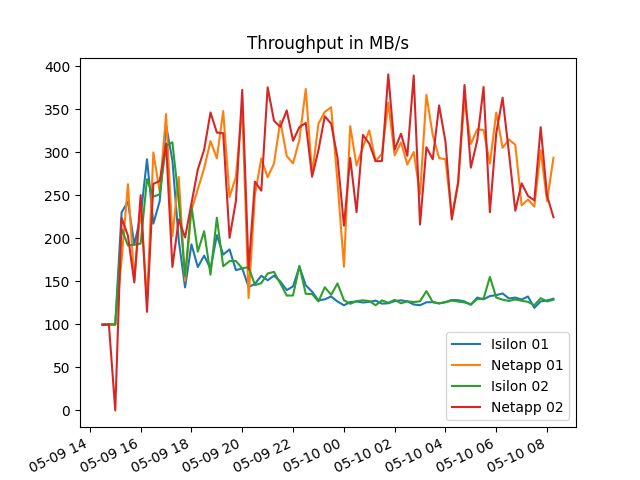

In [21]:
%matplotlib notebook
values_netapp_1 = []
values_netapp_2 = []
values_isilon_1 = []
values_isilon_2 = []

for key in labels:
    value = res[key]
    values_netapp_1.append(value.get(("netapp", 1), 0))
    values_netapp_2.append(value.get(("netapp", 2), 0))
    values_isilon_1.append(value.get(("isilon", 1), 0))
    values_isilon_2.append(value.get(("isilon", 2), 0))

plt.plot(labels, values_isilon_1, label="Isilon 01")
plt.plot(labels, values_netapp_1, label="Netapp 01")
plt.plot(labels, values_isilon_2, label="Isilon 02")
plt.plot(labels, values_netapp_2, label="Netapp 02")

plt.xticks(rotation=25, ha='right')
plt.legend()
plt.title("Throughput in MB/s")
plt.savefig("daytime_evaluation.png",bbox_inches='tight')
plt.show()


                      mean        conf
fio+isilon1 1   273.541730   36.237419
            2   264.637403   23.393714
            4   325.938544   48.026264
            8   342.520034   31.725740
            16  244.056200   97.941468
dd+isilon1  1   162.000000   19.494520
            2   296.400000   85.411683
            4   513.000000   69.127350
            8   637.000000   41.040705
            16  667.200000   25.813475
fio+isilon2 1   299.729644   30.333704
            2   241.121954   11.655913
            4   268.859686   49.703140
            8   286.053682   15.841805
            16  244.464008   33.248627
dd+isilon2  1   220.400000   14.091656
            2   221.000000   18.227526
            4   268.000000   20.777013
            8   265.600000   15.120796
            16  267.200000   13.297984
fio+isilon3 1   206.552128  103.590367
            2   272.064510  189.339545
            4   298.899818  175.276442
            8   322.927844  435.591907
            16  357.68497

<IPython.core.display.Javascript object>


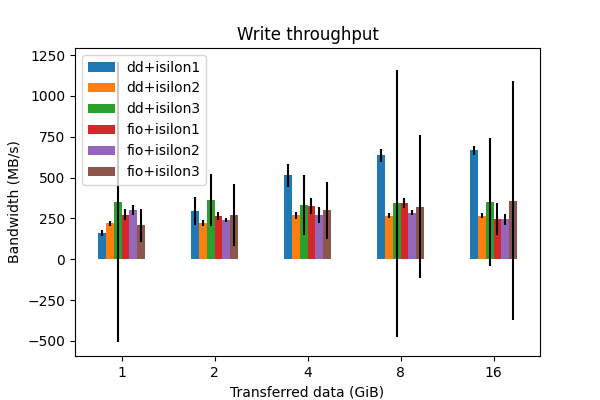

In [11]:
%matplotlib notebook
## Params
pre1 = "2022-05-16T09:47:54_throughput_write_"
pre2 = "2022-05-16T12:29:40_throughput_write_"
pre3 = "2022-05-16T14:05:12_throughput_write_"

## Plot code
pre = result_file_prefix
df = pd.concat({
    "fio+isilon1": load_data(f"../results/{pre1}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon1": load_data(f"../results/{pre1}dd_isilon.json", "bw_in_mb"),
    "fio+isilon2": load_data(f"../results/{pre2}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon2": load_data(f"../results/{pre2}dd_isilon.json", "bw_in_mb"),
    "fio+isilon3": load_data(f"../results/{pre3}fio_isilon.json", "write_bw_mean_in_mb"),
    "dd+isilon3": load_data(f"../results/{pre3}dd_isilon.json", "bw_in_mb"),
    #"fio+netapp": load_data(f"../results/{pre}fio_netapp.json", "write_bw_mean_in_mb"),
    #"dd+netapp": load_data(f"../results/{pre}dd_netapp.json", "bw_in_mb"),
})
df.rename(index={"1G": 1, "2G": 2, "4G": 4, "8G": 8, "16G": 16}, inplace=True)
df.rename(index={"1024": 1, "2048": 2, "4096": 4, "8192": 8, "16384": 16}, inplace=True)
print(df)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Transferred data (GiB)',
    ylabel='Bandwidth (MB/s)',
    title='Write throughput',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()


<IPython.core.display.Javascript object>


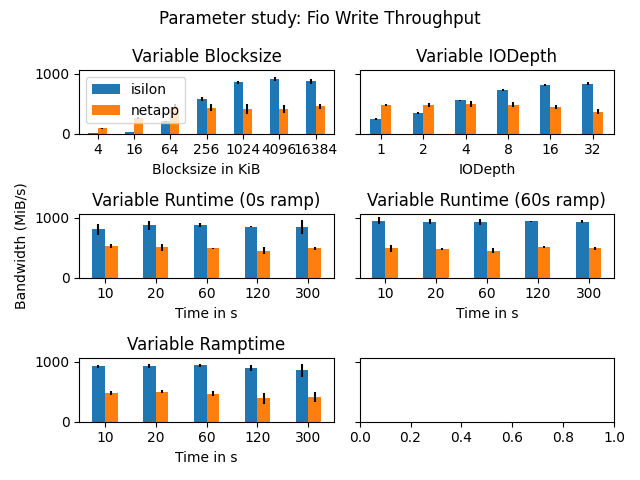

/tmp/ipykernel_77695/3613868433.py:80: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


                    mean       conf
isilon 4        7.205990   0.049997
       16      32.292969   0.809856
       64     204.746797   6.149102
       256    579.365274  30.072417
       1024   853.786193  24.737955
       4096   910.733429  29.984354
       16384  869.811112  43.714855
netapp 4       87.462750   4.999493
       16     265.185082  20.309804
       64     447.823601  43.788631
       256    434.103581  64.064984
       1024   409.589613  85.683408
       4096   408.134115  67.696629
       16384  455.332220  43.959618
                 mean       conf
isilon 1   243.865279  16.237570
       2   341.291905  19.424838
       4   554.324227   6.769503
       8   721.480934  14.601089
       16  809.510225  15.706384
       32  831.850394  23.121739
netapp 1   484.405566  17.774349
       2   477.729926  31.819014
       4   493.453007  42.793895
       8   481.080794  40.283879
       16  446.354906  38.966249
       32  363.100073  41.450016
                  mean        c

In [51]:
%matplotlib notebook
## Params
def func(pre):
    
    post_i = "_isilon.json"
    post_n = "_netapp.json"

    ## Plot code
    df_1 = pd.concat({
        "isilon": load_data(pre+"blocksize"+post_i, "write_bw_mean_in_mb"),
        "netapp": load_data(pre+"blocksize"+post_n, "write_bw_mean_in_mb"),
    })
    df_1.rename(index={"4k": 4, "16k": 16, "64k": 64, "256k": 256, "1024k": 1024, "4096k": 4096, "16384k": 16384}, inplace=True)
    df_2 = pd.concat({
        "isilon": load_data(pre+"iodepth"+post_i, "write_bw_mean_in_mb"),
        "netapp": load_data(pre+"iodepth"+post_n, "write_bw_mean_in_mb"),
    })
    df_2.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32}, inplace=True)
    df_3 = pd.concat({
        "isilon": load_data(pre+"runtime"+post_i, "write_bw_mean_in_mb"),
        "netapp": load_data(pre+"runtime"+post_n, "write_bw_mean_in_mb"),
    })
    df_3.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)
    df_4 = pd.concat({
        "isilon": load_data(pre+"runtime2"+post_i, "write_bw_mean_in_mb"),
        "netapp": load_data(pre+"runtime2"+post_n, "write_bw_mean_in_mb"),
    })
    df_4.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)
    df_5 = pd.concat({
        "isilon": load_data(pre+"runtime3"+post_i, "write_bw_mean_in_mb"),
        "netapp": load_data(pre+"runtime3"+post_n, "write_bw_mean_in_mb"),
    })
    df_5.rename(index={"10": 10, "20": 20, "60": 60, "120": 120, "300": 300}, inplace=True)

    fig, axis = plt.subplots(3, 2, sharey=True, constrained_layout=True)
    fig.suptitle('Parameter study: Fio Write Throughput')

    
    df_1["mean"].unstack(level=0).plot(
        ax=axis[0][0],
        kind='bar', rot=0,
        xlabel='Blocksize in KiB',
        title='Variable Blocksize',
        yerr=df_1["conf"].unstack(level=0)
    )
    df_2["mean"].unstack(level=0).plot(
        ax=axis[0][1],
        kind='bar', rot=0,
        xlabel='IODepth',
        title='Variable IODepth',
        yerr=df_2["conf"].unstack(level=0)
    )

    df_3["mean"].unstack(level=0).plot(
        ax=axis[1][0],
        kind='bar', rot=0,
        xlabel='Time in s',
        ylabel='Bandwidth (MiB/s)',
        title='Variable Runtime (0s ramp)',
        yerr=df_3["conf"].unstack(level=0)
    )
    
    df_4["mean"].unstack(level=0).plot(
        ax=axis[1][1],
        kind='bar', rot=0,
        xlabel='Time in s',
        title='Variable Runtime (60s ramp)',
        yerr=df_4["conf"].unstack(level=0)
    )
    df_5["mean"].unstack(level=0).plot(
        ax=axis[2][0],
        kind='bar', rot=0,
        xlabel='Time in s',
        title='Variable Ramptime',
        yerr=df_5["conf"].unstack(level=0)
    )
    for i,j in [(0,1),(1,0),(1,1),(2,0)]:
        axis[i][j].get_legend().remove()

    plt.tight_layout()
    plt.savefig("paramstudy_throughput.png",bbox_inches='tight')
    plt.show()
    print(df_1)
    print(df_2)
    print(df_3)
    print(df_4)
    print(df_5)
    
#func("/tmp/results/2022-05-16/2022-05-16T13:06:25_throughput_write_")
#func("/tmp/results/2022-05-17/2022-05-17T21:18:41_throughput_write_")
func("./results/2022-05-17T21:18:41_throughput_write_")


# Experiment: Parameter Study - Effect of Blocksize on Bandwidth

<IPython.core.display.Javascript object>


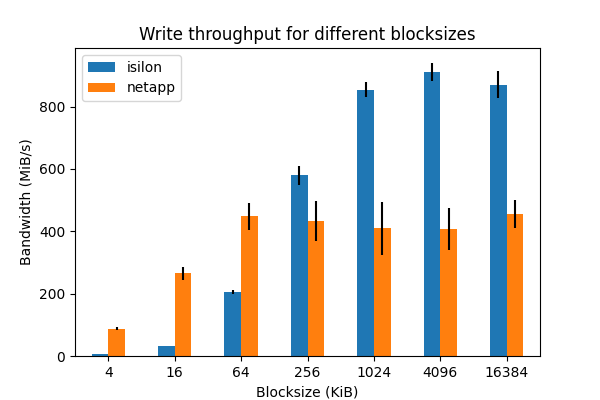

In [22]:
%matplotlib notebook

# Params
result_files = "./results/2022-05-17T21:18:41_throughput_write_blocksize"
    
## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_bw_mean_in_mb"),
    "netapp": load_data(result_files+"_netapp.json", "write_bw_mean_in_mb"),
})
df.rename(index={"4k": 4, "16k": 16, "64k": 64, "256k": 256, "1024k": 1024, "4096k": 4096, "16384k": 16384}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Blocksize (KiB)',
    ylabel='Bandwidth (MiB/s)',
    title='Write throughput for different blocksizes',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()


# Experiment: Parameter Study - Effect of iodepth on Bandwidth

<IPython.core.display.Javascript object>


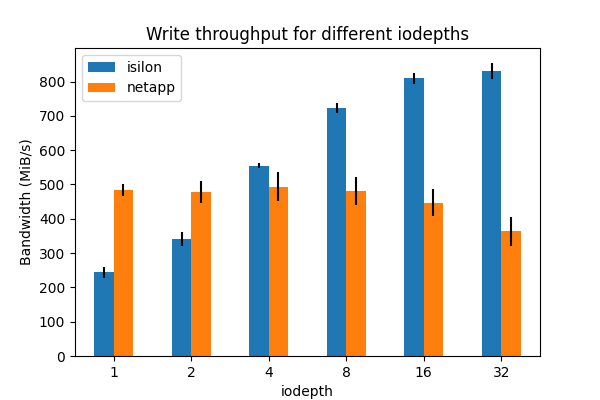

In [37]:
%matplotlib notebook

# Params
result_files = "./results/2022-05-17T21:18:41_throughput_write_iodepth"
    
## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_bw_mean_in_mb"),
    "netapp": load_data(result_files+"_netapp.json", "write_bw_mean_in_mb"),
})
df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='iodepth',
    ylabel='Bandwidth (MiB/s)',
    title='Write throughput for different iodepths',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()

# Experiment: Parameter Study - Effect of Blocksize on IOPS

<IPython.core.display.Javascript object>


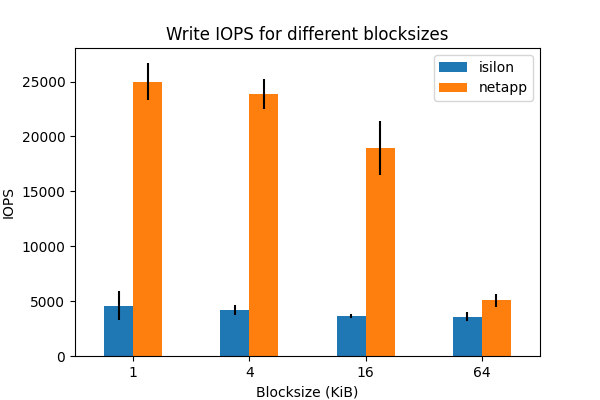

In [23]:
%matplotlib notebook

# Params
result_files = "../results/2022-05-23T21:38:01_iops_write_blocksize"
result_files = "./results/2022-05-29T14:12:33_iops_write_blocksize"
    
## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_iops_mean"),
    "netapp": load_data(result_files+"_netapp.json", "write_iops_mean"),
})
df.rename(index={"1k": 1, "4k": 4, "16k": 16, "64k": 64}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Blocksize (KiB)',
    ylabel='IOPS',
    title='Write IOPS for different blocksizes',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()

# Experiment: Parameter Study - Effect of Filesize on IOPS

<IPython.core.display.Javascript object>


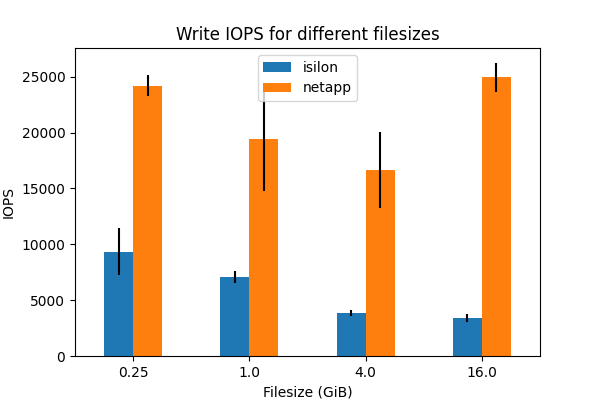

In [42]:
%matplotlib notebook

# Params
result_files = "../results/2022-05-23T21:38:01_iops_write_filesize"
result_files = "./results/2022-05-29T14:12:33_iops_write_filesize"

## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_iops_mean"),
    "netapp": load_data(result_files+"_netapp.json", "write_iops_mean"),
})
df.rename(index={"256M": 0.25, "1G": 1, "4G": 4, "16G": 16}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Filesize (GiB)',
    ylabel='IOPS',
    title='Write IOPS for different filesizes',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()

# Experiment: Parameter Study - Effect of iodepth on IOPS

<IPython.core.display.Javascript object>


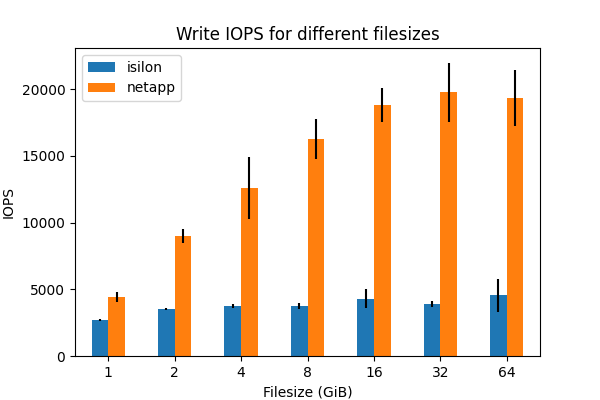

In [47]:
%matplotlib notebook

# Params
result_files = "../results/2022-05-23T21:38:01_iops_write_iodepth"
result_files = "./results/2022-05-29T14:12:33_iops_write_iodepth"

## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_iops_mean"),
    "netapp": load_data(result_files+"_netapp.json", "write_iops_mean"),
})
df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32, "64": 64}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Filesize (GiB)',
    ylabel='IOPS',
    title='Write IOPS for different filesizes',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()

# Experiment: Parameter Study - Effect of numjobs on IOPS

<IPython.core.display.Javascript object>


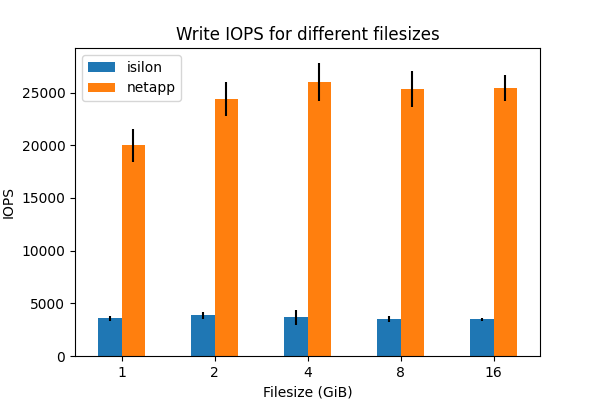

In [48]:
%matplotlib notebook

# Params
result_files = "../results/2022-05-23T21:38:01_iops_write_numjobs"
result_files = "./results/2022-05-29T14:12:33_iops_write_numjobs"

## Plot code
df = pd.concat({
    "isilon": load_data(result_files+"_isilon.json", "write_iops_mean"),
    "netapp": load_data(result_files+"_netapp.json", "write_iops_mean"),
})
df.rename(index={"1": 1, "2": 2, "4": 4, "8": 8, "16": 16, "32": 32, "64": 64}, inplace=True)

ax = df["mean"].unstack(level=0).plot(
    kind='bar', rot=0,
    xlabel='Filesize (GiB)',
    ylabel='IOPS',
    title='Write IOPS for different filesizes',
    figsize=(6, 4),
    yerr=df["conf"].unstack(level=0)
)
plt.show()